## Tensorflow training 1D potential example


Since this is a bit more advanced than the sklearn we recommend you start the other one first

In [7]:
"""First we import our dataset examples"""
import MLTSA
potentials = MLTSA.datasets.one_d_pot
dataset = MLTSA.datasets.one_d_dataset
import matplotlib.pyplot as plt
import numpy as np

#This sets the potentials, don't re-run
total_n_pots = 25
n_DW = 5
relevant_DW_n = 2
#After defining the desired parameters we define the potentials accordingly
pots = potentials(total_n_pots, n_DW, relevant_DW_n)
# This creates the first dataset of data.
# It creates the mixing coefficients don't re-run
n_features = 180
degree_of_mixing = 2
#We specified the number of features wanted and how much they will mix
oneD_dataset = dataset(pots, n_features, degree_of_mixing)


Defining Potentials: 100%|##########| 25/25 [00:00<00:00, 2155.92it/s]


This has set up our dataset for further use, since TensorFlow is more scalable and compatible with GPU calculations, we will do a more extensive search on this example. 

Let's generate the actual linear mixed data we will use for training.   


In [8]:
#Generate the trajectories
n_simulations = 100
n_steps = 500
data, ans = oneD_dataset.generate_linear(n_simulations, n_steps)
data_val, ans_val = oneD_dataset.generate_linear(int(n_simulations/2), n_steps)

#Prepare it for training
time_frame = [30, 60] #Same time frame as the sklearn one
X, Y = oneD_dataset.PrepareData(data, ans, time_frame, mode="Normal")
X_val, Y_val = oneD_dataset.PrepareData(data_val, ans_val, time_frame, mode="Normal")

Generating dataset


Running Simulations: 100%|##########| 100/100 [00:20<00:00,  4.84it/s]


Getting simulation labels for the generated data


Classifying Simulation Outcomes: 100%|##########| 100/100 [00:00<00:00, 546133.33it/s]


Generating dataset


Running Simulations: 100%|##########| 50/50 [00:10<00:00,  4.83it/s]


Getting simulation labels for the generated data


Classifying Simulation Outcomes: 100%|##########| 50/50 [00:00<00:00, 427118.53it/s]


Now this data is generated as (X/Features, Y/labels) but those labels are strings which TensorFlow cannot handle as easy. Let's encode them for our Neural Network. 

In [12]:
#We will convert IN and OUT to numerical labels
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(Y.reshape(len(Y), 1)).toarray()
Y_val = encoder.fit_transform(Y_val.reshape(len(Y_val),1)).toarray()
print(Y[:3])
print(Y_val[:3])
print(Y.shape)
print(X.shape)

[[0. 1.]
 [0. 1.]
 [0. 1.]]
[[1. 0.]
 [1. 0.]
 [1. 0.]]
(3000, 2)
(3000, 180)



Now that we have got the X and Y ready to fit to, we will train the model, in this example we want to train a Multi-Layer Perceptron just like the one in Sklearn, but we will use TensorFlow instead. For this we will have to build the models first using the build_MLP function under the MLTSA_tensorflow integrated package. This will print a summay of our model to check that the dimensions and size for each layer are correct. 


In [13]:
#We will start with the basic Multi-Layer Perceptron
from MLTSA import build_MLP_tf

MLP = build_MLP_tf(n_steps, n_features, n_labels=2).model

Building Simple MLP
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 100)               18100     
                                                                 
 dropout_4 (Dropout)         (None, 100)               0         
                                                                 
 dense_7 (Dense)             (None, 100)               10100     
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_8 (Dense)             (None, 2)                 202       
                                                                 
Total params: 28,402
Trainable params: 28,402
Non-trainable params: 0
_________________________________________________________________
None


Now let's put to train the MLP, in this case we can make use of the fit() function of our model and call the data (X,Y) directly without any other preparation. We will use X_val and Y_val later for further validation. 

In [14]:
from tensorflow.keras.callbacks import EarlyStopping

#In this training we implement the same methodology as in the paper by using early stopping and a maximum of 500 iterations. 
train_log = MLP.fit(X, Y, epochs=500, batch_size=n_steps, verbose=1, validation_split=0.2,
        callbacks=[EarlyStopping(monitor='accuracy', min_delta=1e-4, restore_best_weights=True, patience=100)])

#We use now the X_val and Y_val to evaluate the quality of the training. 
val_acc = MLP.evaluate(X_val, Y_val, verbose=1)

Epoch 1/500
5/5 [==============================] - 1s 53ms/step - loss: 0.7269 - accuracy: 0.5350 - val_loss: 0.7364 - val_accuracy: 0.3500
Epoch 2/500
5/5 [==============================] - 0s 13ms/step - loss: 0.7115 - accuracy: 0.4708 - val_loss: 0.6906 - val_accuracy: 0.6650
Epoch 3/500
5/5 [==============================] - 0s 12ms/step - loss: 0.6950 - accuracy: 0.5246 - val_loss: 0.7791 - val_accuracy: 0.3500
Epoch 4/500
5/5 [==============================] - 0s 14ms/step - loss: 0.6928 - accuracy: 0.5496 - val_loss: 0.7256 - val_accuracy: 0.3500
Epoch 5/500
5/5 [==============================] - 0s 13ms/step - loss: 0.6905 - accuracy: 0.5279 - val_loss: 0.6931 - val_accuracy: 0.4317
Epoch 6/500
5/5 [==============================] - 0s 13ms/step - loss: 0.6900 - accuracy: 0.5371 - val_loss: 0.7242 - val_accuracy: 0.3500
Epoch 7/500
5/5 [==============================] - 0s 13ms/step - loss: 0.6877 - accuracy: 0.5492 - val_loss: 0.7346 - val_accuracy: 0.3500
Epoch 8/500
5/5 [===

In [16]:
print("We achieved", val_acc[1]*100, "% accuracy on Validation and ", max(train_log.history["accuracy"])*100, "% accuracy on Training")

We achieved 90.46666622161865 % accuracy on Validation and  93.54166388511658 % accuracy on Training



The previous training has generated a record of the training, test and validation accuracy as well as the evolution of the loss throughout the epochs. 

These can be plotted to see how the model is learning the outcome. To do this we need to callback the history which is in 


In [17]:
loss  = train_log.history["loss"]
val_loss = train_log.history["val_loss"]
acc_train = train_log.history["accuracy"]
acc_val = train_log.history["val_accuracy"]

Text(0, 0.5, 'loss')

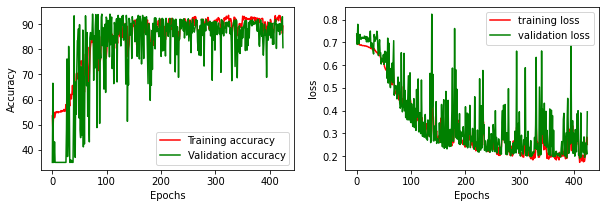

In [18]:
fig, ax = plt.subplots(1,2, figsize=(10,3))
ax[0].plot(np.array(acc_train)*100, color="r", label="Training accuracy")
ax[0].plot(np.array(acc_val)*100, color="g", label="Validation accuracy")
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(loss, label="training loss", color="r")
ax[1].plot(val_loss, label="validation loss", color="g")
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("loss")


Now we can move onto trying the MLTSA for this ML model. For that we call the MLTSA() method within the tensorflow package.


In [19]:
from MLTSA import MLTSA_tfl

a_drop = MLTSA_tfl(data[:,:,time_frame[0]:time_frame[1]], ans, MLP, encoder)

100it [00:27,  3.69it/s]


Text(0, 0.5, 'Accuracy (%)')

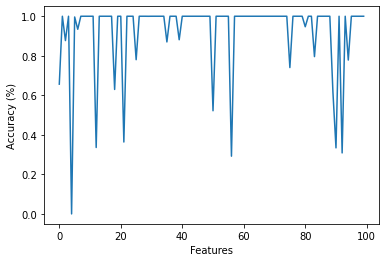

In [20]:
plt.plot(np.mean(a_drop, axis=0));
plt.xlabel("Features")
plt.ylabel("Accuracy (%)")

We call the MLTSA_Plot function to visualize if the Neural Network detects the important features. 

/home/ucapzwe/.local/lib/python3.8/site-packages/MLTSA/MLTSA_tensorflow/MLTSA_tf.py:108: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(dat, "-o", color="black", marker="s")


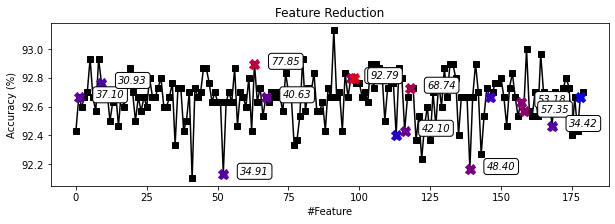

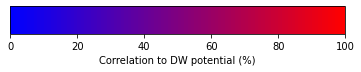

In [21]:
from MLTSA import MLTSA_plot_tf

MLTSA_plot_tf(a_drop.T, oneD_dataset, pots, errorbar=False)